# Multimodal Emotion Recognition (MELD)

The goal of this project is the development of a reliable multimodal system for automatic emotion classification using state-of-the-art deep learning models for natural language and speech processing.

The proposed system employs a pre-trained **BERT** model for the representation and processing of textual data, as well as the **wav2vec 2.0 model** for acoustic feature extraction from speech signals. Information from different modalities is integrated through **multimodal fusion techniques** on the **MELD dataset**.

Two fusion strategies are investigated: early fusion and late fusion. **Early fusion** performs joint modeling of textual and acoustic features at an early stage, while **late fusion** combines independently learned modality-specific representations at a later decision level.

## 1. Setup and Configuration


### Environment Setup
Standard libraries for data processing, audio signal handling, and deep learning are loaded. In addition, the required packages for audio processing, working with pre-trained models, and PyTorch-based implementation are installed and configured.

In [ ]:
# System setup and dependencies

!sudo apt-get update
!sudo apt-get install ffmpeg
!pip install torch==2.9.0 torchvision==0.24.0 torchaudio==2.9.0 --index-url https://download.pytorch.org/whl/cu126

In [ ]:
# Additional Python packages for AI/Audio/NLP

!pip -q install transformers datasets accelerate sentencepiece

!pip install -q librosa soundfile

!pip install torchcodec==0.8.0

In [3]:
import numpy as np
import pandas as pd
import time
import math
import random
import os
import shutil
import subprocess
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path

# PyTorch ecosystem imports
import torch
import torchaudio
import torchcodec
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Hugging Face transformers - Multimodal Models
from transformers import (
    Wav2Vec2Processor,
    Wav2Vec2Model,

    BertConfig,
    BertModel,
    BertTokenizer
)

from sklearn.utils.class_weight import compute_class_weight

# Progress bar for iterations
from tqdm.auto import tqdm

# Evalution metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Google Drive is used to store the MELD dataset and to save the processed audio embeddings.
from google.colab import drive
drive.mount('/content/drive')

### Configuration
All project parameters are defined in a centralized configuration dictionary to ensure clarity, consistency and reproducibility of experiments. The configuration includes dataset specifications, model architecture parameters, fusion settings, training hyperparameters, evaluation criteria, and hardware selection.

To ensure experimental reproducibility, all sources of randomness are controlled by explicitly setting a global random seed. By fixing the random seed and centralizing all parameters within the configuration dictionary, the experimental setup can be reliably reproduced across different runs and hardware environments.

In [5]:
# Project configuration (DICTIONARY FORMAT)

CONFIG = {
    # Dataset parameters
    "dataset_name": "declare-lab/MELD",
    "emotion_labels": ["neutral", "joy", "surprise", "anger", "sadness", "fear", "disgust"],

    # Sample limits for faster testing
    "max_train_samples": None,   # Original: 9989
    "max_val_samples": None,     # Original: 1109
    "max_test_samples": None,    # Original: 2610

    # Models parameters
    "bert_model": "bert-base-uncased",
    "wav2vec_model": "facebook/wav2vec2-base",
    "bert_hidden_size": 768,
    "wav2vec_hidden_size": 768,
    "max_text_length": 128,
    "audio_sampling_rate": 16000,
    "text_embedding_dim": 768,
    "audio_embedding_dim": 768,

    # Early Fusion
    "fusion_input_dim": 1536,
    "fusion_hidden_dim":512,
    "fusion_dropout":0.3,
    "num_classes": 7,

    # Training hyperparameters
    "batch_size": 32,
    "num_epochs": 30,
    "learning_rate": 1e-4,
    "weight_decay": 1e-4,
    "early_stopping_patience": 5,

    # Evaluation
    "eval_metrics": ["accuracy", "weighted_f1", "confusion_matrix"],
    "random_seed": 42,

    # Hardware
    "device": "cuda" if torch.cuda.is_available() else "cpu",

     # Project info
    "project_name": "Multimodal Emotion Recognition in Conversations",
}

def print_config(config):
    """Display configuration in a readable format"""
    print("=" * 70)
    print(f"CONFIGURATION: {config['project_name']}")
    print("=" * 70)

    sections = {
        "Dataset": ["dataset_name", "emotion_labels", "max_train_samples"],
        "Models": ["bert_model", "wav2vec_model", "bert_hidden_size","wav2vec_hidden_size"],
        "Training": ["batch_size", "num_epochs", "learning_rate", "weight_decay"],
        "Hardware": ["device"],
        "Evaluation": ["eval_metrics", "random_seed"]
    }

    for section, keys in sections.items():
        print(f"\n[{section}]")
        for key in keys:
            if key in config:
                value = config[key]
                if isinstance(value, list) and len(value) > 3:
                    print(f"  {key}: [{value[0]}, {value[1]}, ..., {value[-1]}] (len={len(value)})")
                else:
                    print(f"  {key}: {value}")
        print("=" * 70)

# Display configuration
print_config(CONFIG)

CONFIGURATION: Multimodal Emotion Recognition in Conversations

[Dataset]
  dataset_name: declare-lab/MELD
  emotion_labels: [neutral, joy, ..., disgust] (len=7)
  max_train_samples: None

[Models]
  bert_model: bert-base-uncased
  wav2vec_model: facebook/wav2vec2-base
  bert_hidden_size: 768
  wav2vec_hidden_size: 768

[Training]
  batch_size: 32
  num_epochs: 30
  learning_rate: 0.0001
  weight_decay: 0.0001

[Hardware]
  device: cuda

[Evaluation]
  eval_metrics: ['accuracy', 'weighted_f1', 'confusion_matrix']
  random_seed: 42


In [6]:
# Set seeds
def set_seed(seed=42):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Use seed from CONFIG
set_seed(CONFIG["random_seed"])


print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch: 2.9.0+cu128
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.6 GB


### Paths and Directory Structure
This section defines the directory structure used in the project, separating
runtime data from persistent Google Drive storage.
Directories are organized for raw data, processed audio files, CSV metadata,
and extracted embeddings, and are created automatically to ensure reproducibility.


In [7]:

# ROOT DIRECTORIES
RUNTIME_ROOT = Path("/content")
DRIVE_ROOT = Path("/content/drive/MyDrive/datasets/MELD")
MODEL_ROOT = Path("/content/drive/MyDrive/models")
FINE_TUNED_MODEL_PATH = Path("/content/drive/MyDrive/models/checkpoints/best_model.pt")

# RAW MELD DATA
# Directory where the original MELD dataset will be extracted
MELD_RAW_ROOT = RUNTIME_ROOT / "meld_raw"

# Dataset splits after extraction
MELD_TRAIN_DIR = MELD_RAW_ROOT / "train"
MELD_DEV_DIR   = MELD_RAW_ROOT / "dev"
MELD_TEST_DIR  = MELD_RAW_ROOT / "test"


# FILTERED / PROCESSED DATA
MELD_FILTERED_ROOT = RUNTIME_ROOT / "meld_filtered"

# Local audio and CSV files
AUDIO_WAV_DIR = DRIVE_ROOT / "meld_filtered" / "audio_wav"
CSV_LOCAL_DIR = DRIVE_ROOT / "meld_filtered" / "csv"

# CSV Files (GOOGLE DRIVE)
CSV_DRIVE_DIR = DRIVE_ROOT / "meld_filtered" / "csv"

TRAIN_CSV_PATH = CSV_DRIVE_DIR / "train_sent_emo.csv"
VAL_CSV_PATH   = CSV_DRIVE_DIR / "dev_sent_emo.csv"
TEST_CSV_PATH  = CSV_DRIVE_DIR / "test_sent_emo.csv"

# EMBEDDINGS
AUDIO_EMBEDDINGS_DIR = DRIVE_ROOT / "embeddings"
TEXT_EMBEDDINGS_DIR  = DRIVE_ROOT / "embeddings_text"


# Create required directories
for p in [
    MELD_RAW_ROOT,
    MELD_TRAIN_DIR, MELD_DEV_DIR, MELD_TEST_DIR,
    MELD_FILTERED_ROOT,
    AUDIO_WAV_DIR, CSV_LOCAL_DIR,
    AUDIO_EMBEDDINGS_DIR, TEXT_EMBEDDINGS_DIR,
    MODEL_ROOT
]:
    p.mkdir(parents=True, exist_ok=True)

## 2. Dataset Preparation

### Dataset Download and Extraction
The MELD dataset is downloaded and extracted into separate directories for train, validation, and test splits. Audio files (originally MP4) are converted to mono WAV at 16 kHz to ensure compatibility with the wav2vec 2.0 model.



In [ ]:
!wget -O meld.zip https://huggingface.co/datasets/declare-lab/MELD/resolve/main/MELD.Raw.tar.gz

In [ ]:
# Unzip MELD dataset
!tar -xvzf meld.zip -C {MELD_RAW_ROOT}

# Unzip splits
!tar -xvzf {MELD_RAW_ROOT}/MELD.Raw/train.tar.gz -C {MELD_TRAIN_DIR}
!tar -xvzf {MELD_RAW_ROOT}/MELD.Raw/dev.tar.gz   -C {MELD_DEV_DIR}
!tar -xvzf {MELD_RAW_ROOT}/MELD.Raw/test.tar.gz  -C {MELD_TEST_DIR}

In [ ]:
# Find all MP4 files recursive
mp4_files = list(MELD_RAW_ROOT.rglob("*.mp4"))
print("Found MP4 files:", len(mp4_files))

for mp4 in tqdm(mp4_files):
    wav_path = AUDIO_WAV_DIR / f"{mp4.stem}.wav"

    if wav_path.exists():
        continue

    subprocess.run(
        [
            "ffmpeg",
            "-y",
            "-i", str(mp4),
            "-ac", "1",
            "-ar", "16000",
            str(wav_path)
        ],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )

print("MP4 → WAV conversion finished.")

In [ ]:
from pathlib import Path

print("MELD_RAW_ROOT exists?", MELD_RAW_ROOT.exists())
print("Contents:", list(MELD_RAW_ROOT.glob("*")))


In [ ]:
# Copy WAV files
!find "{str(MELD_RAW_ROOT)}" -type f -name "*.wav" -exec cp {{}} "{str(AUDIO_WAV_DIR)}" \;

# Copy CSV files
!find "{str(MELD_RAW_ROOT)}" -type f -name "*.csv" -exec cp {{}} "{str(CSV_LOCAL_DIR)}" \;

# Copy on Google Drive
!cp -r {MELD_FILTERED_ROOT} {DRIVE_ROOT}

### Loading CSV Metadata
This section loads the CSV metadata files for the training, validation, and test splits
and prints their dimensions to verify successful loading.




In [8]:
train_df = pd.read_csv(TRAIN_CSV_PATH)
val_df   = pd.read_csv(VAL_CSV_PATH)
test_df  = pd.read_csv(TEST_CSV_PATH)

print(train_df.shape, val_df.shape, test_df.shape)

(9989, 11) (1109, 11) (2610, 11)


### Data Preprocessing
Emotion labels are mapped from textual categories to numerical class indices to enable
model training.
For each utterance, the absolute path to the corresponding WAV audio file is constructed
based on its dialogue and utterance identifiers.
Column names are standardized to ensure consistency across dataset splits.

In [9]:
# Map emotion labels to numeric classes
EMOTION_MAP = {
    "neutral": 0,
    "joy": 1,
    "surprise": 2,
    "anger": 3,
    "sadness": 4,
    "fear": 5,
    "disgust": 6
}

# Build absolute path to WAV audio file
def build_audio_path(dialogue_id, utterance_id):
    return AUDIO_WAV_DIR / f"dia{dialogue_id}_utt{utterance_id}.wav"

# Prepare DataFrame for audio-based emotion classification
def prepare_df(df):
    # Create a copy of the dataframe to avoid in-place modifications
    df = df.copy()

    # Map emotion labels to numeric classes
    df["label"] = df["Emotion"].map(EMOTION_MAP)

    # Build the path to the corresponding audio file for each utterance
    df["audio_path"] = df.apply(
    lambda x: build_audio_path(x.Dialogue_ID, x.Utterance_ID),
    axis=1
)
    # Standardize column names
    df.rename(columns={"Utterance": "utterance"}, inplace=True)
    return df

# Apply preprocessing to train, val and test splits
train_df = prepare_df(train_df)
val_df   = prepare_df(val_df)
test_df  = prepare_df(test_df)

In [ ]:
print(train_df.iloc[0]["audio_path"])
print(os.path.exists(train_df.iloc[0]["audio_path"]))

### Audio Data Verification
A sample audio file is loaded and played to verify that the audio preprocessing was performed correctly.



In [ ]:
from IPython.display import Audio

sample_path = train_df.iloc[0]["audio_path"]
Audio(sample_path)

## 6. Audio Embeddings (Wav2Vec 2.0)

A custom PyTorch Dataset class loads waveform–label pairs, converting audio to mono and truncating signals to 6 seconds for consistent input length.

Audio features are extracted using the pre-trained Wav2Vec 2.0 model. Each waveform is processed with the corresponding Wav2Vec processor and passed through the model to obtain hidden representations at the frame level.

Since Wav2Vec 2.0 produces variable-length temporal sequences, a temporal pooling strategy is applied to convert frame-level representations into fixed-size utterance-level embeddings. Specifically, both the mean and the standard deviation are computed across the time dimension of the last hidden layer. The final audio embedding is obtained by combining these two statistics, which allows the model to capture both the average acoustic characteristics and the temporal variability of the signal.

This pooling strategy provides a more expressive representation compared to mean pooling alone, as it preserves information about dynamic changes in the audio over time.

Embeddings and their associated labels are saved in .pt files for the train, validation, and test splits and are later used as inputs for the multimodal classification pipeline.

In [ ]:
wav2vec_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

wav2vec_model = Wav2Vec2Model.from_pretrained(
    "facebook/wav2vec2-base"
).to(CONFIG["device"])

wav2vec_model.eval()

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/211 [00:00<?, ?it/s]

Wav2Vec2Model LOAD REPORT from: facebook/wav2vec2-base
Key                          | Status     |  | 
-----------------------------+------------+--+-
quantizer.weight_proj.bias   | UNEXPECTED |  | 
project_q.bias               | UNEXPECTED |  | 
project_hid.bias             | UNEXPECTED |  | 
quantizer.weight_proj.weight | UNEXPECTED |  | 
quantizer.codevectors        | UNEXPECTED |  | 
project_hid.weight           | UNEXPECTED |  | 
project_q.weight             | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [ ]:
class MELDAudioDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "audio_path"]
        label = self.df.loc[idx, "label"]

        waveform, sr = torchaudio.load(path)
        waveform = waveform.mean(dim=0)       # mono
        waveform = waveform[: sr * 6]          # max 6 seconds

        return waveform, label

In [ ]:
def extract_audio_embeddings(df, save_path):
    dataset = MELDAudioDataset(df)
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    embeddings, labels = [], []

    with torch.no_grad():
        for waveform, label in tqdm(loader):
            waveform = waveform.squeeze().numpy()

            inputs = wav2vec_processor(
                waveform,
                sampling_rate=16000,
                return_tensors="pt"
            ).input_values.to(CONFIG["device"])

            outputs = wav2vec_model(inputs)

            hidden_states = outputs.last_hidden_state
            mean_pool = hidden_states.mean(dim=1)
            std_pool  = hidden_states.std(dim=1)

            emb = mean_pool + std_pool

            embeddings.append(emb.cpu())
            labels.append(label)

            del emb, inputs, outputs
            torch.cuda.empty_cache()

    torch.save(
        {
            "embeddings": torch.cat(embeddings),
            "labels": torch.tensor(labels)
        },
        save_path
    )

In [ ]:
extract_audio_embeddings(
    train_df,
    AUDIO_EMBEDDINGS_DIR / "audio_train.pt"
)
extract_audio_embeddings(
    val_df,
    AUDIO_EMBEDDINGS_DIR / "audio_val.pt"
)
extract_audio_embeddings(
    test_df,
    AUDIO_EMBEDDINGS_DIR / "audio_test.pt"
)


In [10]:
train_data = torch.load(AUDIO_EMBEDDINGS_DIR / "audio_train.pt")
val_data   = torch.load(AUDIO_EMBEDDINGS_DIR / "audio_val.pt")
test_data  = torch.load(AUDIO_EMBEDDINGS_DIR / "audio_test.pt")

train_audio_embeddings = train_data["embeddings"]
val_audio_embeddings = val_data["embeddings"]
test_audio_embeddings = test_data["embeddings"]

train_labels = train_data["labels"]
val_labels = val_data["labels"]
test_labels = test_data["labels"]

print(train_audio_embeddings.shape, train_labels.shape)

torch.Size([9989, 768]) torch.Size([9989])


## 7. Text Embeddings (BERT)

Textual features are extracted using a pre-trained BERT model. Each utterance is tokenized and encoded, then passed through the model to obtain contextualized representations. A fixed-size sentence embedding is derived from the output and used as the text modality input for the multimodal system.

The resulting embeddings and corresponding labels are stored for the train, validation, and test splits and later combined with audio features in the fusion stage.

In [ ]:
# Load tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(CONFIG["device"])
bert_model.eval()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
class MELDTextDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.loc[idx, "utterance"]
        label = self.df.loc[idx, "label"]
        return text, label


In [ ]:
def extract_text_embeddings(df, save_path, max_length=128):
    dataset = MELDTextDataset(df)
    loader = DataLoader(dataset, batch_size=8, shuffle=False)

    embeddings, labels = [], []

    with torch.no_grad():
        for texts, batch_labels in tqdm(loader):
            inputs = bert_tokenizer(
                list(texts),
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            )

            input_ids = inputs["input_ids"].to(CONFIG["device"])
            attention_mask = inputs["attention_mask"].to(CONFIG["device"])

            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden = outputs.last_hidden_state  # (batch_size, seq_len, hidden_dim)

            # Mean pooling over valid tokens
            mask = attention_mask.unsqueeze(-1).expand(last_hidden.size()).float()
            summed = torch.sum(last_hidden * mask, dim=1)
            counts = torch.clamp(mask.sum(dim=1), min=1e-9)
            mean_pooled = summed / counts  # (batch_size, hidden_dim)

            embeddings.append(mean_pooled.cpu())
            labels.append(batch_labels)

            del inputs, outputs, mean_pooled
            torch.cuda.empty_cache()

    torch.save(
        {
            "embeddings": torch.cat(embeddings),
            "labels": torch.cat(labels)
        },
        save_path
    )


In [ ]:
extract_text_embeddings(
    train_df,
    TEXT_EMBEDDINGS_DIR / "text_train.pt",
    max_length=CONFIG["max_text_length"]
)

extract_text_embeddings(
    val_df,
    TEXT_EMBEDDINGS_DIR / "text_val.pt",
    max_length=CONFIG["max_text_length"]
)

extract_text_embeddings(
    test_df,
    TEXT_EMBEDDINGS_DIR / "text_test.pt",
    max_length=CONFIG["max_text_length"]
)


In [11]:
train_data = torch.load(TEXT_EMBEDDINGS_DIR / "text_train.pt")
val_data   = torch.load(TEXT_EMBEDDINGS_DIR / "text_val.pt")
test_data  = torch.load(TEXT_EMBEDDINGS_DIR / "text_test.pt")

train_text_embeddings = train_data["embeddings"]
val_text_embeddings = val_data["embeddings"]
test_text_embeddings = test_data["embeddings"]

#train_labels     = train_data["labels"]

print(train_text_embeddings.shape, train_labels.shape)


torch.Size([9989, 768]) torch.Size([9989])


## Dataset Definition

In [12]:
class MultimodalDataset(Dataset):
    def __init__(self, text_embeddings, audio_embeddings, labels):
        self.text_embeddings = text_embeddings
        self.audio_embeddings = audio_embeddings
        self.labels = labels

    # Return the total number of samples
    def __len__(self):
        return len(self.labels)

    # Return one multimodal sample
    def __getitem__(self, idx):
        return (
            self.text_embeddings[idx],
            self.audio_embeddings[idx],
            self.labels[idx]
        )

## Model Definitions

### Early Fusion Model  (Concatenation + MLP)

The early fusion approach is implemented by concatenating textual and audio embeddings of dimension 768, extracted using the BERT and wav2vec 2.0 models. In this way, a joint multimodal representation of dimension 1536 is formed, combining information from both modalities.

The resulting fused vector is passed to a multilayer perceptron (MLP) consisting of linear layers with ReLU activation functions and dropout regularization, which helps reduce the risk of overfitting. The final layer performs emotion classification, while the softmax function is implicitly applied through the cross-entropy loss function.

In [ ]:
# Early Fusion model for multimodal emotion recognition.
class EarlyFusionMLP(nn.Module):
  def __init__(self, config):
    super(EarlyFusionMLP, self).__init__()

    # Dimension of the fused multimodal representation
    fusion_dim = config["text_embedding_dim"] + config["audio_embedding_dim"]

    # Multilayer perceptron used for classification
    self.classifier = nn.Sequential(
        nn.Linear(fusion_dim, config["fusion_hidden_dim"]),
        nn.ReLU(),
        nn.Dropout(p=config["fusion_dropout"]),

        nn.Linear(config["fusion_hidden_dim"], 256),
        nn.ReLU(),
        nn.Dropout(p=config["fusion_dropout"]),

        nn.Linear(256, config["num_classes"])
      )

  # Forward pass of the model.
  def forward(self, text_emb, audio_emb):
    # Concatenate text and audio embeddings along the feature dimension
    fused = torch.cat((text_emb, audio_emb),dim = 1)
    # Pass the fused representation through the classifier
    logits = self.classifier(fused)
    return logits

### Unimodal Baseline Models
Separate classifiers are defined for text-only and audio-only emotion recognition.


In [ ]:
# Text-only classifier based on BERT embeddings
class TextClassifier(nn.Module):

    def __init__(self, config):
        super(TextClassifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(config["text_embedding_dim"], 256),
            nn.ReLU(),
            nn.Dropout(config["fusion_dropout"]),
            nn.Linear(256, config["num_classes"])
        )

    def forward(self, text_emb):
        return self.classifier(text_emb)


In [13]:
# Audio-only classifier based on wav2vec 2.0 embeddings
class AudioClassifier(nn.Module):
    def __init__(self, config):
        super(AudioClassifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(config["audio_embedding_dim"], 256),
            nn.ReLU(),
            nn.Dropout(config["fusion_dropout"]),
            nn.Linear(256, config["num_classes"])
        )

    def forward(self, audio_emb):
        return self.classifier(audio_emb)


## Training and Evaluation Utilities

This section defines shared training, evaluation, and visualization utilities used across all models and fusion strategies. The `Trainer` class provides a unified training pipeline supporting text-only, audio-only, and early fusion modes, including loss computation, optimization, learning rate scheduling, checkpointing, and early stopping based on validation F1-score.

Given the inherent class imbalance present in the MELD dataset, the training utilities optionally support class-weighted Cross-Entropy loss. When enabled, class-specific weights are incorporated into the loss function to penalize misclassification of underrepresented emotion classes more heavily, thereby reducing bias toward majority classes and promoting more balanced learning. This mechanism is particularly important for improving recall and F1-score on minority emotions.

Late fusion is evaluated separately by combining independently trained text and audio model logits via a weighted average at inference time. Model performance is assessed using accuracy, weighted F1-score, and confusion matrices, while additional visualization utilities enable per-class and fusion-level performance analysis.



In [14]:
class Trainer:
  def __init__(self, model, train_loader, val_loader, config, mode="early_fusion",use_class_weights=False):
    self.model = model
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.config = config
    self.mode =mode

    self.device = torch.device(config["device"])
    self.model.to(self.device)

    if use_class_weights:
      self.criterion = nn.CrossEntropyLoss(weight=class_weights)
    else:
      self.criterion = nn.CrossEntropyLoss()
    self.optimizer = Adam(self.model.parameters(), lr=config["learning_rate"])
    self.scheduler = ReduceLROnPlateau(self.optimizer, mode='max', patience=2)

    self.best_f1 = 0.0
    self.epochs_no_improve = 0

    self.ckpt_dir = MODEL_ROOT / "checkpoints"
    self.ckpt_dir.mkdir(parents=True, exist_ok=True)
    self.ckpt_path = self.ckpt_dir / f"{mode}_best.pt"

  def _forward(self, batch):
    text, audio, labels = batch
    if self.mode == "early_fusion":
      logits = self.model(text, audio)
    elif self.mode == "text":
      logits = self.model(text)
    elif self.mode == "audio":
      logits = self.model(audio)
    else:
      raise ValueError("Unknown mode")
    return logits, labels

  def train_epoch(self):
    self.model.train()
    total_loss = 0
    for batch in self.train_loader:
      batch = [b.to(self.device) for b in batch]
      self.optimizer.zero_grad()
      logits, labels = self._forward(batch)
      loss = self.criterion(logits, labels)
      loss.backward()
      self.optimizer.step()
      total_loss += loss.item()
    return total_loss / len(self.train_loader)

  def evaluate(self, return_cm=False):
      self.model.eval()
      preds, targets = [], []

      with torch.no_grad():
          for batch in self.val_loader:
              batch = [b.to(self.device) for b in batch]
              logits, labels = self._forward(batch)

              preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
              targets.extend(labels.cpu().numpy())

      acc = accuracy_score(targets, preds)
      f1 = f1_score(targets, preds, average="weighted")

      if return_cm:
          cm = confusion_matrix(targets, preds)
          return{
            "accuracy": acc,
            "f1": f1,
            "y_true": targets,
            "y_pred": preds,
            "confusion_matrix": cm
          }

      return acc, f1

  def save_checkpoint(self, epoch, f1):
    torch.save({
      'epoch': epoch,
      'model_state': self.model.state_dict(),
      'optimizer_state': self.optimizer.state_dict(),
      'f1': f1,
      'mode': self.mode,
      'config': self.config
    }, self.ckpt_path)

  def fit(self):
    for epoch in range(self.config["num_epochs"]):
      train_loss = self.train_epoch()
      val_acc, val_f1 = self.evaluate()
      self.scheduler.step(val_f1)

      print(f"[{self.mode}] Epoch {epoch+1}: loss={train_loss:.4f}, val_f1={val_f1:.4f}")

      if val_f1 > self.best_f1:
        self.best_f1 = val_f1
        self.epochs_no_improve = 0
        self.save_checkpoint(epoch, val_f1)
      else:
        self.epochs_no_improve += 1

      if self.epochs_no_improve >= self.config["early_stopping_patience"]:
        print("Early stopping triggered")
        break

In [ ]:
def load_model(path, device='cpu'):
    ckpt = torch.load(path, map_location=device)
    config = ckpt['config']
    mode = ckpt.get('mode', 'early_fusion')

    if mode == "early_fusion":
        model = EarlyFusionMLP(config)
    elif mode == "text":
        model = TextClassifier(config)
    elif mode == "audio":
        model = AudioClassifier(config)
    else:
        raise ValueError(f"Unknown model mode: {mode}")

    model.load_state_dict(ckpt['model_state'])
    model.to(device)
    model.eval()
    return model


In [ ]:
# Evaluates late fusion model (average or weighted).
def evaluate_late_fusion(text_model, audio_model, dataloader, device, alpha=0.5):
    text_model.eval()
    audio_model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for text_emb, audio_emb, labels in dataloader:
            text_logits = text_model(text_emb.to(device))
            audio_logits = audio_model(audio_emb.to(device))

            fused_logits = alpha * text_logits + (1 - alpha) * audio_logits
            all_preds.extend(torch.argmax(fused_logits, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    cm = confusion_matrix(all_labels, all_preds)

    return{
            "accuracy": acc,
            "f1": f1,
            "y_true": all_labels,
            "y_pred": all_preds,
            "confusion_matrix": cm
    }

In [15]:
# Plots a confusion matrix for classification results.
def plot_confusion_matrix(
    y_true,
    y_pred,
    class_names,
    title="Confusion Matrix",
    figsize=(8, 6),
    cmap="Blues"
):
    cm = confusion_matrix(y_true, y_pred)

    # Row-normalized percentages (recall view)
    row_sums = cm.sum(axis=1, keepdims=True)
    cm_percent = cm.astype(np.float32) / np.clip(row_sums, 1e-8, None) * 100

    # Build annotations: "count\n(xx.x%)"
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)"

    plt.figure(figsize=figsize)
    sns.heatmap(
        cm,
        annot=annot,
        fmt="",
        cmap=cmap,
        xticklabels=class_names,
        yticklabels=class_names,
        square=True
    )

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title + " (Counts + Row %)")
    plt.tight_layout()
    plt.show()


In [16]:
# Plots per-class F1-scores as a bar chart.
def plot_per_class_f1(
    y_true,
    y_pred,
    class_names,
    title="Per-class F1-score",
    figsize=(8, 5),
):
    _, _, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        labels=range(len(class_names)),
        average=None,
        zero_division=0
    )

    f1_percent = f1 * 100
    x = np.arange(len(class_names))

    plt.figure(figsize=figsize)
    bars = plt.bar(x, f1_percent)

    plt.xticks(x, class_names, rotation=45, ha="right")
    plt.ylabel("F1-score (%)")
    plt.ylim(0, 100)
    plt.title(title)
    plt.grid(axis="y", alpha=0.3)

    # annotate bars
    for bar, score in zip(bars, f1_percent):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 1,
            f"{score:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9
        )

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_per_class_f1_comparison(
    y_true_audio, y_pred_audio,
    y_true_text, y_pred_text,
    y_true_early, y_pred_early,
    y_true_late, y_pred_late,
    class_names,
    figsize=(11, 5)
):

    def compute_f1_percent(y_true, y_pred):
        _, _, f1, _ = precision_recall_fscore_support(
            y_true, y_pred,
            labels=range(len(class_names)),
            average=None,
            zero_division=0
        )
        return f1 * 100

    f1_audio = compute_f1_percent(y_true_audio, y_pred_audio)
    f1_text  = compute_f1_percent(y_true_text,  y_pred_text)
    f1_early = compute_f1_percent(y_true_early, y_pred_early)
    f1_late  = compute_f1_percent(y_true_late,  y_pred_late)

    group_gap = 2
    x = np.arange(len(class_names)) * group_gap

    width = 0.4

    plt.figure(figsize=figsize)

    bars_audio = plt.bar(x - 1.6*width, f1_audio, width, label="Audio")
    bars_text  = plt.bar(x - 0.5*width, f1_text,  width, label="Text")
    bars_early = plt.bar(x + 0.5*width, f1_early, width, label="Early Fusion")
    bars_late  = plt.bar(x + 1.6*width, f1_late,  width, label="Late Fusion")

    plt.xticks(x, class_names, rotation=45, ha="right")
    plt.ylabel("F1-score (%)")
    plt.ylim(0, 100)
    plt.title("Per-class F1-score Comparison")
    plt.grid(axis="y", alpha=0.3)

    # Bold best model per class
    all_f1 = np.vstack([f1_audio, f1_text, f1_early, f1_late])
    best_indices = np.argmax(all_f1, axis=0)
    all_bars = [bars_audio, bars_text, bars_early, bars_late]

    for class_idx, best_model_idx in enumerate(best_indices):
        bar = all_bars[best_model_idx][class_idx]
        bar.set_edgecolor("black")
        bar.set_linewidth(2.5)

    # Smart text positioning
    for bars in all_bars:
        for bar in bars:
            h = bar.get_height()

            if h < 5:
                offset = 2.5
            elif h < 20:
                offset = 2.0
            else:
                offset = 1.2

            plt.text(
                bar.get_x() + bar.get_width()/2,
                h + offset,
                f"{h:.1f}%",
                ha="center",
                va="bottom",
                fontsize=7
            )

    plt.legend()
    plt.tight_layout()
    plt.show()



### Multimodal Dataset Construction
Text and audio embeddings are grouped into a `MultimodalDataset` for train, validation, and test splits. DataLoaders are used to load data in batches, with shuffling applied only during training.




In [17]:
# Create datasets
train_dataset = MultimodalDataset(
    train_text_embeddings,
    train_audio_embeddings,
    train_labels
)

val_dataset = MultimodalDataset(
    val_text_embeddings,
    val_audio_embeddings,
    val_labels
)
test_dataset = MultimodalDataset(
    test_text_embeddings,
    test_audio_embeddings,
    test_labels
)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False)

### Computation of Class Weights

Class weights are computed from the training labels to address class imbalance in the dataset. The labels are first converted to a NumPy array and reshaped into a one-dimensional format to ensure compatibility with the weighting procedure.

The balanced weighting scheme is then applied using the inverse class frequency, assigning higher weights to underrepresented emotion classes and lower weights to more frequent ones. These weights are finally converted to a PyTorch tensor and transferred to the appropriate device for efficient use during training.

This approach ensures that the loss function reflects the true distribution of the training data and supports more balanced model optimization.

In [18]:
train_labels = train_dataset.labels

if isinstance(train_labels, torch.Tensor):
    train_labels = train_labels.cpu().numpy()

train_labels = train_labels.reshape(-1)

classes = np.unique(train_labels)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=train_labels
)

class_weights = torch.tensor(
    class_weights, dtype=torch.float
).to(CONFIG["device"])


## Model Training




### Early Fusion Training

In [ ]:
# Early fusion model
early_fusion_model  = EarlyFusionMLP(CONFIG).to(CONFIG["device"])

# Training
trainer_early_fusion = Trainer(
    early_fusion_model,
    train_loader,
    val_loader,
    CONFIG,
    mode = "early_fusion",
    use_class_weights=True)
trainer_early_fusion.fit()

[early_fusion] Epoch 1: loss=1.8360, val_f1=0.5042
[early_fusion] Epoch 2: loss=1.6401, val_f1=0.5256
[early_fusion] Epoch 3: loss=1.5432, val_f1=0.5247
[early_fusion] Epoch 4: loss=1.4937, val_f1=0.5081
[early_fusion] Epoch 5: loss=1.4571, val_f1=0.5269
[early_fusion] Epoch 6: loss=1.4219, val_f1=0.4880
[early_fusion] Epoch 7: loss=1.3891, val_f1=0.5112
[early_fusion] Epoch 8: loss=1.3624, val_f1=0.5481
[early_fusion] Epoch 9: loss=1.3362, val_f1=0.5512
[early_fusion] Epoch 10: loss=1.3274, val_f1=0.5338
[early_fusion] Epoch 11: loss=1.3028, val_f1=0.5571
[early_fusion] Epoch 12: loss=1.2783, val_f1=0.5619
[early_fusion] Epoch 13: loss=1.2539, val_f1=0.5003
[early_fusion] Epoch 14: loss=1.2377, val_f1=0.5362
[early_fusion] Epoch 15: loss=1.2089, val_f1=0.5387
[early_fusion] Epoch 16: loss=1.1603, val_f1=0.5564
[early_fusion] Epoch 17: loss=1.1427, val_f1=0.5566
Early stopping triggered


### Training Unimodal Baseline Models


In [ ]:
text_model = TextClassifier(CONFIG).to(CONFIG["device"])
trainer_text_baseline = Trainer(
    text_model,
    train_loader,
    val_loader,
    CONFIG,
    mode="text",
    use_class_weights=True
)
trainer_text_baseline.fit()


[text] Epoch 1: loss=1.8184, val_f1=0.4899
[text] Epoch 2: loss=1.6316, val_f1=0.5148
[text] Epoch 3: loss=1.5414, val_f1=0.5051
[text] Epoch 4: loss=1.4973, val_f1=0.5302
[text] Epoch 5: loss=1.4653, val_f1=0.5189
[text] Epoch 6: loss=1.4389, val_f1=0.5380
[text] Epoch 7: loss=1.4202, val_f1=0.5416
[text] Epoch 8: loss=1.3946, val_f1=0.5376
[text] Epoch 9: loss=1.3859, val_f1=0.5600
[text] Epoch 10: loss=1.3764, val_f1=0.5569
[text] Epoch 11: loss=1.3613, val_f1=0.5326
[text] Epoch 12: loss=1.3487, val_f1=0.5562
[text] Epoch 13: loss=1.3286, val_f1=0.5393
[text] Epoch 14: loss=1.3238, val_f1=0.5447
Early stopping triggered


In [ ]:
audio_model = AudioClassifier(CONFIG).to(CONFIG["device"])
trainer_audio_baseline = Trainer(
    audio_model,
    train_loader,
    val_loader,
    CONFIG,
    mode="audio",
    use_class_weights=True
)
trainer_audio_baseline.fit()

[audio] Epoch 1: loss=1.9348, val_f1=0.1672
[audio] Epoch 2: loss=1.9198, val_f1=0.2077
[audio] Epoch 3: loss=1.9033, val_f1=0.2866
[audio] Epoch 4: loss=1.8965, val_f1=0.2310
[audio] Epoch 5: loss=1.8908, val_f1=0.2199
[audio] Epoch 6: loss=1.8881, val_f1=0.1874
[audio] Epoch 7: loss=1.8735, val_f1=0.2278
[audio] Epoch 8: loss=1.8744, val_f1=0.2338
Early stopping triggered


## Model Evaluation


### Load best Models
The best-performing models (based on validation performance) are loaded for final evaluation.


In [ ]:
early_fusion_model = load_model(
    MODEL_ROOT / "checkpoints" / "early_fusion_best.pt",
    CONFIG["device"]
)
trainer_early = Trainer(
    model=early_fusion_model,
    train_loader=None,
    val_loader=test_loader,
    config=CONFIG,
    mode="early_fusion",
    use_class_weights=True
)

In [ ]:
text_model = load_model(MODEL_ROOT / "checkpoints" / "text_best.pt", CONFIG["device"])
audio_model = load_model(MODEL_ROOT / "checkpoints" / "audio_best.pt", CONFIG["device"])

In [ ]:
trainer_text = Trainer(
    text_model,
    None,
    test_loader,
    CONFIG,
    mode="text",
    use_class_weights=True
)

trainer_audio = Trainer(
    audio_model,
    None,
    test_loader,
    CONFIG,
    mode="audio",
    use_class_weights=True
)

### Quantitative Evaluation Metrics

Models are evaluated using accuracy and weighted F1-score.

In [ ]:
early_fusion_results  = trainer_early.evaluate(return_cm=True)


In [ ]:
text_results = trainer_text.evaluate(return_cm=True)

text_acc = text_results["accuracy"]
text_f1  = text_results["f1"]

In [ ]:
audio_results = trainer_audio.evaluate(return_cm=True)

audio_acc = audio_results["accuracy"]
audio_f1  = audio_results["f1"]

In [ ]:
late_fusion_results = evaluate_late_fusion(
    text_model=text_model,
    audio_model=audio_model,
    dataloader=test_loader,
    device=CONFIG["device"],
    alpha=0.5
)

### Confusion Matrix Analysis

Confusion matrices provide insight into class-wise prediction behavior.

Audio model confusion matrix

The Audio model shows weak overall performance and struggles to distinguish most emotions. The model mostly predicts **neutral**, which leads to many misclassifications from other emotions into neutral. Recognition of **joy**, **surprise**, **anger**, **sadness**, **fear** and **disgust** is poor, with low recall across almost all non-neutral classes. Many emotions such as **fear** and **disgust** are almost never correctly detected.


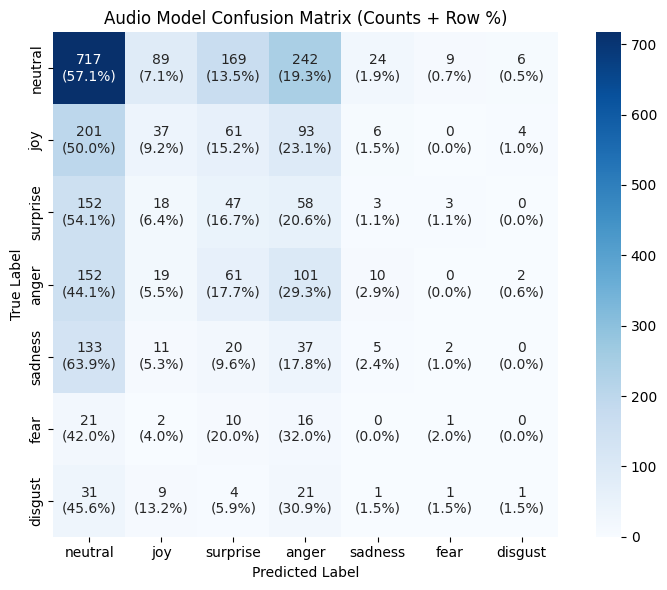

In [ ]:
plot_confusion_matrix(
    y_true=audio_results["y_true"],
    y_pred=audio_results["y_pred"],
    class_names=CONFIG["emotion_labels"],
    title="Audio Model Confusion Matrix")

Text model confusion matrix

The Text model performs significantly better than the Audio model across most emotion classes. Strong recognition is observed for **neutral**, **joy** and **surprise**, with high correct classification rates. The model achieves moderate performance for **anger** and **sadness**, but still shows confusion with neutral and other emotions. **Fear** and **disgust** remain challenging, though the model detects them better than the Audio model.

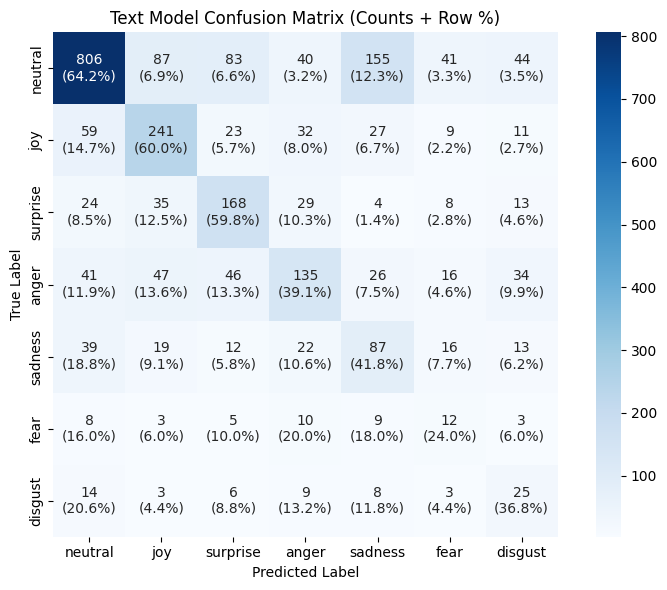

In [ ]:
plot_confusion_matrix(
    y_true=text_results["y_true"],
    y_pred=text_results["y_pred"],
    class_names=CONFIG["emotion_labels"],
    title="Text Model Confusion Matrix")

Early Fusion Confusion Matrix

Early Fusion combines audio and text features and shows improved balance across emotion classes. The model performs well on **neutral**, **joy** and **surprise**, similar to or slightly below the Text model. Recognition of **anger** and **sadness** improves compared to unimodal models.

The model shows better detection of minority emotions such as **fear** and **disgust** compared to Audio alone. Some confusion still exists between emotionally similar classes (e.g., sadness vs neutral, anger vs surprise).




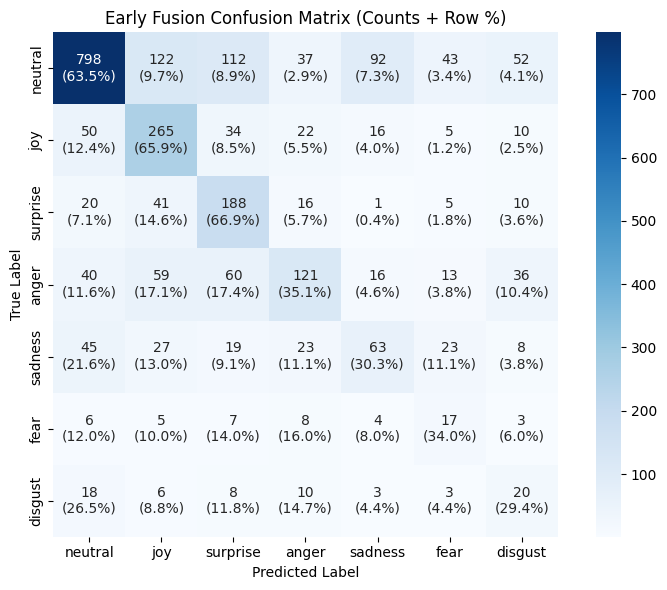

In [ ]:
plot_confusion_matrix(
    y_true=early_fusion_results["y_true"],
    y_pred=early_fusion_results["y_pred"],
    class_names=CONFIG["emotion_labels"],
    title="Early Fusion Confusion Matrix")

Late Fusion Confusion Matrix

Late Fusion also improves over the Audio model but behaves differently from Early Fusion. Strong performance is observed for **neutral**, **joy** and **surprise**, though slightly weaker than Early Fusion in some minority classes. **Sadness** and **anger** are reasonably detected but still confused with neutral. **Fear** and **disgust** remain difficult and are often misclassified. The confusion matrix shows that Late Fusion still inherits some bias toward neutral predictions.




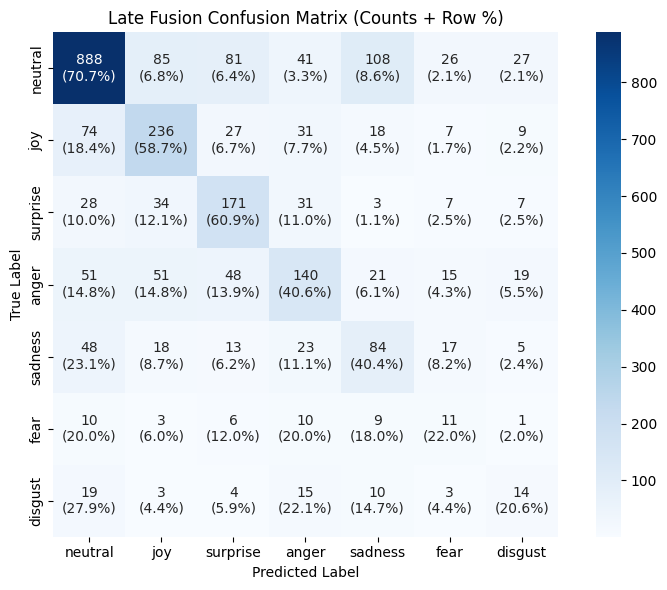

In [ ]:
plot_confusion_matrix(
    y_true=late_fusion_results["y_true"],
    y_pred=late_fusion_results["y_pred"],
    class_names=CONFIG["emotion_labels"],
    title="Late Fusion Confusion Matrix")

### Per-class F1-score Analysis

Per-class F1-scores are visualized to analyze performance differences across emotion categories.


Audio model

The Audio model shows strong performance only for the **neutral** class (53.8%), while all other emotions remain significantly lower. Emotions such as **fear** (3.0%), **sadness** (3.9%) and **disgust** (2.5%) are particularly challenging, indicating that audio features alone struggle to capture subtle emotional differences. Overall, the Audio model demonstrates limited effectiveness for fine-grained emotion recognition.


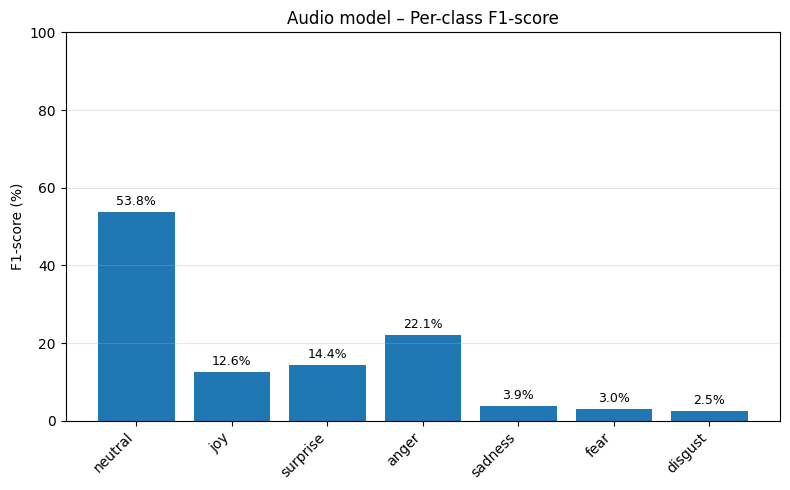

In [ ]:
plot_per_class_f1(
    y_true=audio_results["y_true"],
    y_pred=audio_results["y_pred"],
    class_names=CONFIG["emotion_labels"],
    title="Audio model – Per-class F1-score"
)

Text model
The Text model achieves consistently higher scores across most emotion classes compared to the Audio model. It performs best on **neutral** (71.7%), followed by **joy** (57.6%) and **surprise** (53.8%). Performance decreases for less frequent and more subtle emotions such as **fear** (15.5%) and **disgust** (23.7%), but remains noticeably stronger than the Audio model. This indicates that textual information carries rich emotional cues and is highly effective for emotion recognition.

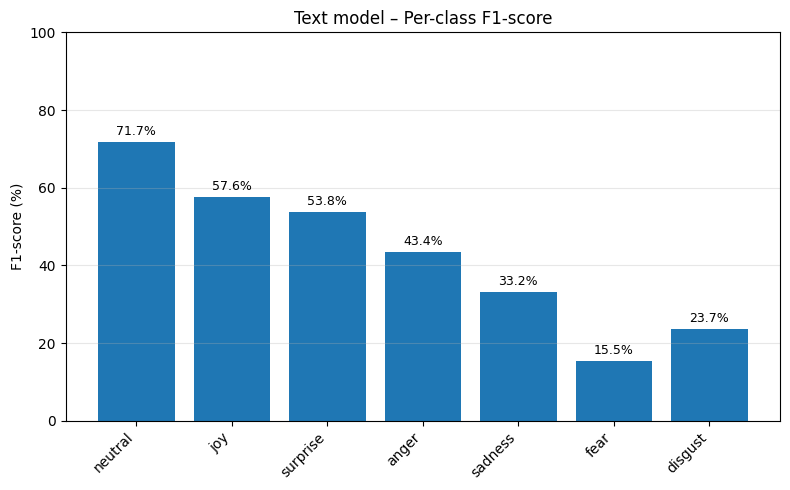

In [ ]:
plot_per_class_f1(
    y_true=text_results["y_true"],
    y_pred=text_results["y_pred"],
    class_names=CONFIG["emotion_labels"],
    title="Text model – Per-class F1-score"
)

Early Fusion

The Early Fusion model provides balanced performance across emotion classes by combining audio and text features at an early stage. It achieves strong results for **neutral** (71.5%), **joy** (57.2%) and **surprise** (53.0%), while also improving recognition of harder emotions such as **sadness** (31.3%), **fear** (21.4%) and **disgust** (19.3%) compared to single-modality models. This suggests that early multimodal integration helps capture complementary emotional information.









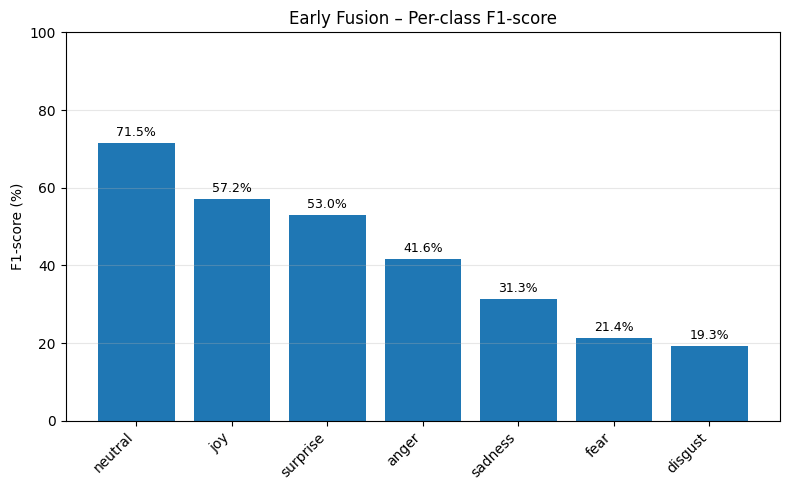

In [ ]:
plot_per_class_f1(
    y_true=early_fusion_results["y_true"],
    y_pred=early_fusion_results["y_pred"],
    class_names=CONFIG["emotion_labels"],
    title="Early Fusion – Per-class F1-score"
)

Late Fusion model

The Late Fusion model achieves the highest performance for **neutral** (74.8%) and maintains strong results for **joy** (56.7%) and **surprise** (54.2%). However, its performance on difficult emotions such as **fear** (16.2%) and **disgust** (18.7%) is slightly lower than Early Fusion. While Late Fusion improves overall accuracy, it is less balanced across emotion classes compared to Early Fusion.


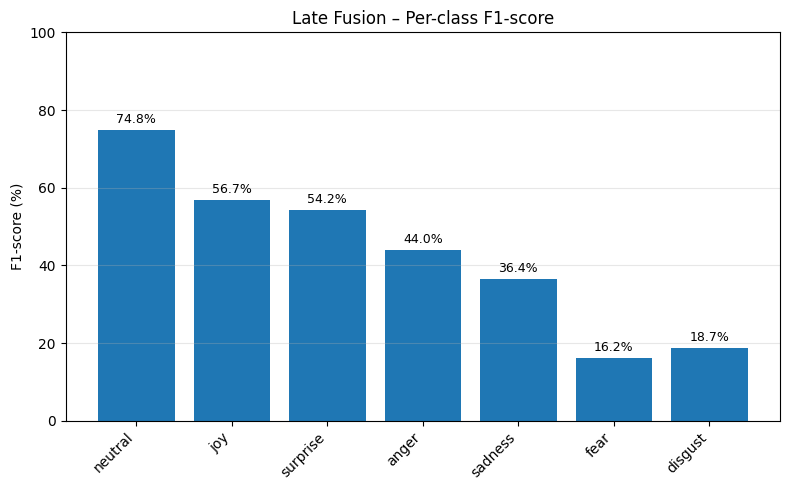

In [ ]:
plot_per_class_f1(
    y_true=late_fusion_results["y_true"],
    y_pred=late_fusion_results["y_pred"],
    class_names=CONFIG["emotion_labels"],
    title="Late Fusion – Per-class F1-score"
)

## Results

Table summarizes the performance of all models. The **Text baseline** outperforms the **Audio baseline**, indicating that text features are more informative. **Early fusion** achieves performance comparable to the Text baseline but does not provide a clear improvement. **Late fusion** achieves the best overall performance in terms of both accuracy and weighted F1-score.





In [ ]:
results_df = pd.DataFrame({
    "Model": [
        "Text baseline",
        "Audio baseline",
        "Early fusion",
        "Late fusion"
    ],
    "Accuracy": [
        text_results["accuracy"],
        audio_results["accuracy"],
        early_fusion_results["accuracy"],
        late_fusion_results["accuracy"]
    ],
    "Weighted F1": [
        text_results["f1"],
        audio_results["f1"],
        early_fusion_results["f1"],
        late_fusion_results["f1"]
    ]
})

results_df


,Model,Accuracy,Weighted F1
0,Text baseline,0.564751,0.584883
1,Audio baseline,0.348276,0.327621
2,Early fusion,0.563985,0.578116
3,Late fusion,0.591571,0.600937


The figure compares per-class F1-scores across four models: Audio, Text, Early Fusion, and Late Fusion.
The comparison shows that multimodal fusion improves overall emotion recognition compared to the Audio-only model. Late Fusion achieves the highest performance for dominant and frequent emotions such as neutral, anger, and sadness, while Early Fusion shows slightly better robustness for more difficult emotions like fear.

However, the Text model emerges as the strongest single-modality model, consistently outperforming the Audio model across all emotion classes and achieving performance comparable to fusion approaches for several emotions, particularly joy, surprise, and disgust. This indicates that textual information carries the most discriminative emotional cues in the dataset.

Overall, while fusion methods provide more balanced performance across classes, the Text model alone already captures a large portion of emotional information, making it a highly effective baseline for emotion recognition


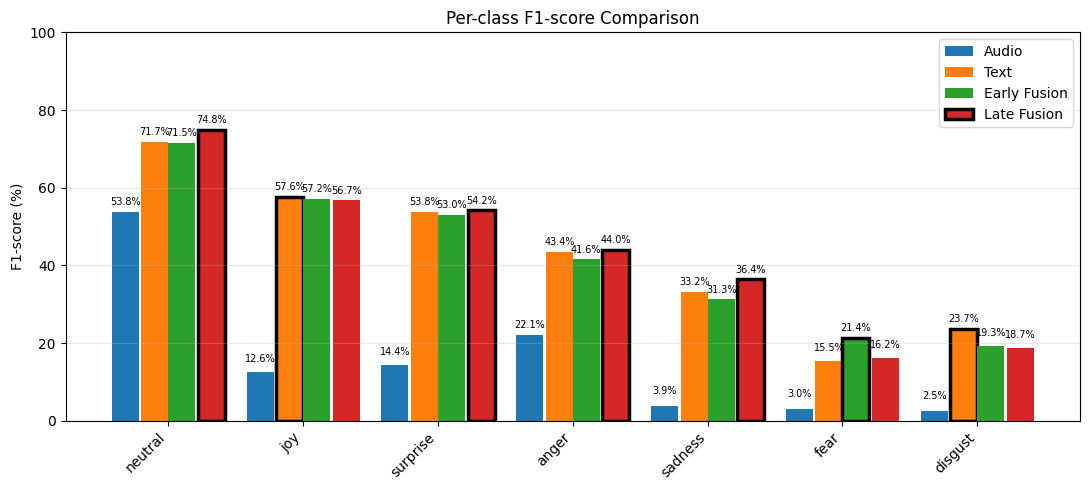

In [ ]:
plot_per_class_f1_comparison(
    audio_results["y_true"],
    audio_results["y_pred"],
    text_results["y_true"],
    text_results["y_pred"],
    early_fusion_results["y_true"],
    early_fusion_results["y_pred"],
    late_fusion_results["y_true"],
    late_fusion_results["y_pred"],
    class_names=CONFIG["emotion_labels"],
)

## Evaluation of the Fine-Tuned Audio Model on the MELD Test Set

In [35]:
checkpoint = torch.load(
    FINE_TUNED_MODEL_PATH,
    map_location=CONFIG["device"]
)

fine_tuned_audio_model = AudioClassifier(CONFIG).to(CONFIG["device"])
fine_tuned_audio_model.load_state_dict(checkpoint, strict=True)

<All keys matched successfully>

In [36]:
trainer_ft_audio = Trainer(
    fine_tuned_audio_model,
    None,
    test_loader,
    CONFIG,
    mode="audio",
    use_class_weights=True
)

The fine-tuned model shows **lower overall Accuracy and Weighted F1** compared to the baseline.


In [37]:
ft_audio_results = trainer_ft_audio.evaluate(return_cm=True)

print(f"Fine-Tuned Audio Model TP CW accuracy: { ft_audio_results["accuracy"]:.4f}")
print(f"Fine-Tuned Audio Model TP CW weighted F1: {ft_audio_results["f1"]:.4f}")

Fine-Tuned Audio Model TP CW accuracy: 0.2073
Fine-Tuned Audio Model TP CW weighted F1: 0.2112


Fine-tuned model (Temporal Pooling + Class Weights)
- Reduced neutral bias
- Much better **joy and sadness detection**
- More balanced prediction distribution
- Still struggles with **surprise and disgust**
Fine-tuning with  improves class balance and minority emotion recognition, but introduces some loss in dominant-class accuracy. The model becomes less biased and more emotion-sensitive overall, though rare emotions remain challenging.


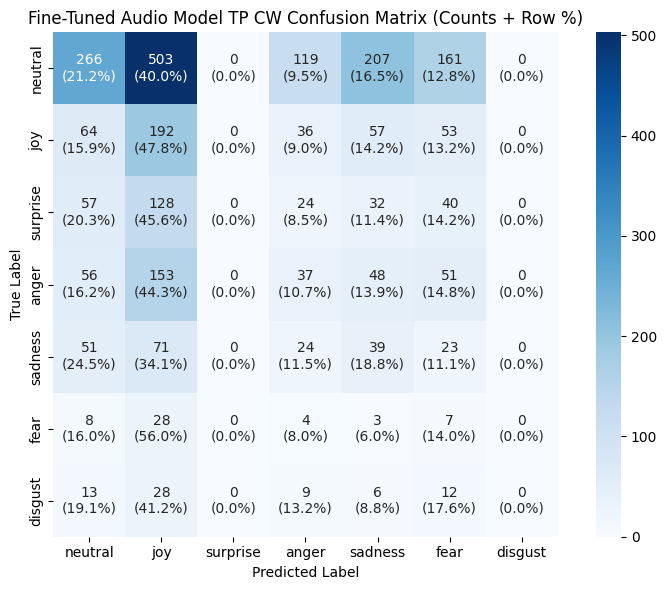

In [38]:
plot_confusion_matrix(
    y_true=ft_audio_results["y_true"],
    y_pred=ft_audio_results["y_pred"],
    class_names=CONFIG["emotion_labels"],
    title="Fine-Tuned Audio Model TP CW Confusion Matrix")

The **fine-tuned model improves minority emotions**, especially:
  - **Joy** (+13%)
  - **Sadness** (+9%)
  - Slight improvement for **fear**
  - Performance on the **neutral class decreases**, indicating less bias toward the dominant class.
  - **Surprise and disgust collapse to 0**, suggesting insufficient training data or class imbalance even after weighting.

The baseline model achieves higher performance on dominant classes, but the fine-tuned model provides **more balanced emotion recognition**, improving several underrepresented emotions.

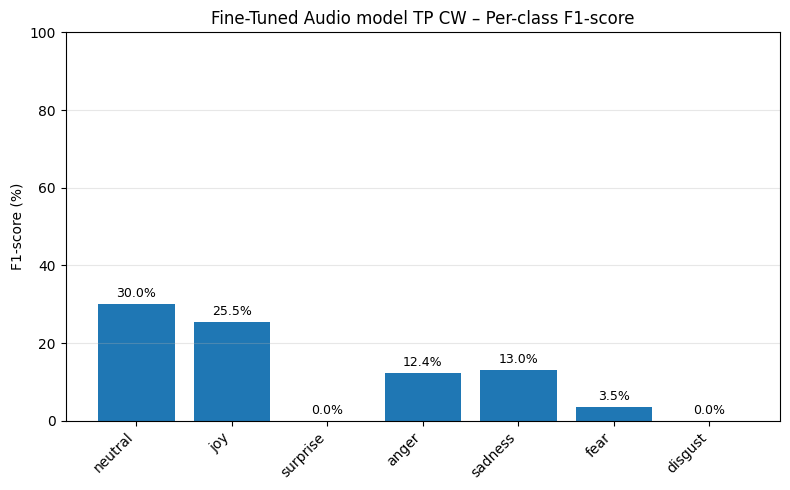

In [39]:
plot_per_class_f1(
    y_true=ft_audio_results["y_true"],
    y_pred=ft_audio_results["y_pred"],
    class_names=CONFIG["emotion_labels"],
    title="Fine-Tuned Audio model TP CW – Per-class F1-score"
)